## Using Versatile Behavior Diffusion (VBD) with GPUDrive

---

> [VBD project page](https://sites.google.com/view/versatile-behavior-diffusion?pli=1) | [ArXiv](https://arxiv.org/abs/2404.02524)

---

In this notebook we demonstrate how you can generate realistic vehicle trajectories with VBD.

In [7]:
# Dependencies
import os
from pathlib import Path
import torch
import warnings
import mediapy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

from pygpudrive.env.config import EnvConfig, RenderConfig, SceneConfig, SelectionDiscipline
from pygpudrive.env.env_torch import GPUDriveTorchEnv

# Plotting
sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (8, 3)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel("WARNING")

## Configuration

 - We only control valid agents up to a maximum of 32
- The initialization steps: 10
- We use the `StateDynamics` model
    - this model has a 5D action `(x, y, yaw, velocity x, velocity y)`

In [13]:
INIT_STEPS = 10

scene_config = SceneConfig(
    path="data/examples", 
    num_scenes=1,
    discipline=SelectionDiscipline.K_UNIQUE_N,
    k_unique_scenes=1,
)

env_config = EnvConfig(
    init_steps=INIT_STEPS, # Warmup period
    enable_vbd=True, # Use VBD
    dynamics_model="state", # Use state-based dynamics model
)

render_config = RenderConfig(
    draw_obj_idx=True,
    render_init=True,
)

## Make environment with 1 scenario


In [14]:
env = GPUDriveTorchEnv(
    config=env_config,
    scene_config=scene_config,
    render_config=render_config,
    max_cont_agents=32, # Maximum number of agents to control per scene
    device="cpu",
    action_type="continuous",
)


--- Ratio unique scenes / number of worls =         1 / 1 ---



In [15]:
# Sanity check: We have a warmup period of 10 steps, so the first step should be 11
env.reset();
env.step_in_episode

selected_agents = torch.nonzero(env.cont_agent_mask[0, :]).flatten().tolist()

print(f"Selected agents: {selected_agents}")

Selected agents: [0, 1, 5]


### Sanity check: Show the initialization logs

In [16]:
len(env.init_frames)

10

In [17]:
mediapy.show_video(images=env.init_frames, title=f'First {INIT_STEPS} steps, initialization with logged trajectories', width=500, loop=False)

Scenario at t = 10

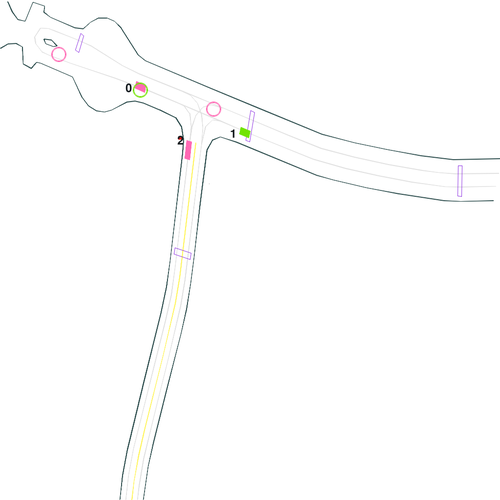

In [19]:
mediapy.show_image(image=env.render(), title=f"Scenario at t = {env.step_in_episode}", width=500)

## Load trained VBD model

In [39]:
# Load model
from vbd.sim_agent.sim_actor import VBDTest, sample_to_action

ckpt_path = 'vbd/weights/epoch=18.ckpt'

model = VBDTest.load_from_checkpoint(ckpt_path, map_location=torch.device('cpu'))
_ = model.cuda()
_ = model.eval()

## Sanity checks

- `sample_batch` shapes

In [40]:
sample_batch = env.warmup_trajectory
for key in sample_batch.keys():
    print(key, sample_batch[key].shape)

agents_history torch.Size([1, 32, 11, 8])
agents_interested torch.Size([1, 32])
agents_type torch.Size([1, 32])
agents_future torch.Size([1, 32, 80, 5])
traffic_light_points torch.Size([1, 16, 3])
polylines torch.Size([1, 256, 30, 5])
polylines_valid torch.Size([1, 256])
relations torch.Size([1, 304, 304, 3])
agents_id torch.Size([1, 3])
anchors torch.Size([1, 32, 64, 2])


- Check distributions of agent history

In [41]:
# env, num_controlled_agents, init_steps, features
sample_batch['agents_history'][:, selected_agents, :, :].shape

torch.Size([1, 3, 11, 8])

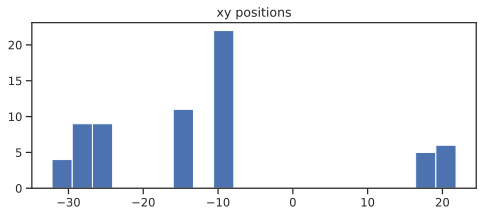

In [42]:
plt.title('xy positions')
plt.hist(sample_batch['agents_history'][:, selected_agents, :, 0:2].cpu().flatten(), bins=20);

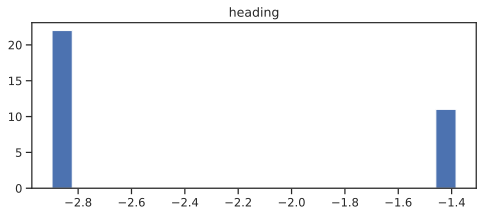

In [43]:
plt.title('heading')
plt.hist(sample_batch['agents_history'][:, selected_agents, :, 2].cpu().flatten(), bins=20);

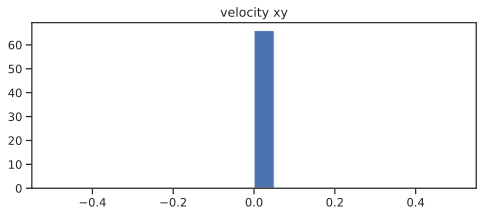

In [44]:
plt.title('velocity xy')
plt.hist(sample_batch['agents_history'][:, selected_agents, :, 3:5].cpu().flatten(), bins=20);

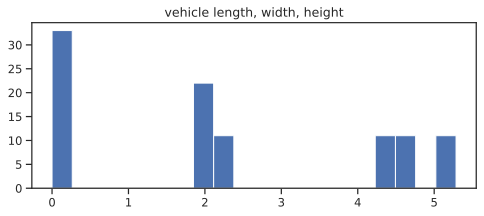

In [45]:
plt.title('vehicle length, width, height')
plt.hist(sample_batch['agents_history'][:, selected_agents, :, 5:].cpu().flatten(), bins=20);

- Check `agents_interested`

In [46]:
sample_batch['agents_interested']

tensor([[10., 10.,  1.,  1.,  1., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.]], device='cuda:0')

- Check `agents_type`

In [47]:
sample_batch['agents_type']

tensor([[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')

- Check `polylines`

In [48]:
sample_batch['polylines'].shape # TODO: Check

torch.Size([1, 256, 30, 5])

In [49]:
pd.DataFrame(sample_batch['polylines'].cpu().flatten()).describe().T

,count,mean,std,min,25%,50%,75%,max
0,38400.0,0.197645,8.503555,-98.984116,0.0,0.0,0.0,99.584061


- Check `relations`

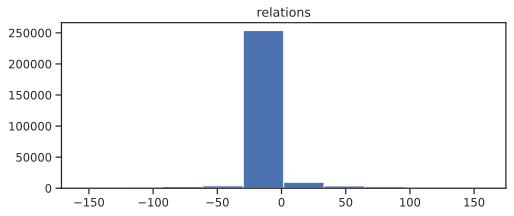

In [50]:
plt.title('relations')
plt.hist(sample_batch['relations'].cpu().flatten());

- Check `agents_id`

In [51]:
sample_batch["agents_id"]

tensor([[0, 1, 5]], device='cuda:0')

## Rollout without goal guidance

In [52]:
sample_batch['polylines'].shape

torch.Size([1, 256, 30, 5])

In [34]:
sample_batch['polylines'] = torch.zeros((1, 256, 30, 5))

In [35]:
replan_freq=80 # Roll out every X steps 80 means openloop
model.early_stop=0 # Stop Diffusion Early From 100 to X
model.skip = 1 # Skip Alpha 
model.reward_func = None

# Reset the environment
init_state = env.reset()

current_state = init_state

# Obtain all info for diffusion model (warmup)
sample_batch = env.warmup_trajectory

# Make a prediction
pred = model.sample_denoiser(sample_batch) # x_t=x_t)
traj_pred = pred['denoised_trajs'].cpu().numpy()[0]

is_controlled = sample_batch['agents_interested'] > 0

Diffusion: 100%|██████████| 50/50 [00:01<00:00, 36.98it/s]


In [38]:
traj_pred

array([[[-3.2194366e+01, -2.7979492e+01, -2.8812068e+00, -0.0000000e+00,
         -0.0000000e+00],
        [-3.2194366e+01, -2.7979492e+01, -2.8836987e+00, -0.0000000e+00,
         -0.0000000e+00],
        [-3.2194366e+01, -2.7979492e+01, -2.8896577e+00, -0.0000000e+00,
         -0.0000000e+00],
        ...,
        [-3.2595119e+01, -2.7877516e+01, -3.4140873e+00, -4.0767601e-01,
          1.1392332e-01],
        [-3.2631634e+01, -2.7867819e+01, -3.4011884e+00, -3.6513123e-01,
          9.6974730e-02],
        [-3.2686501e+01, -2.7854000e+01, -3.3883142e+00, -5.4865378e-01,
          1.3817993e-01]],

       [[ 1.6602600e+01, -1.4858398e+01, -2.8983870e+00, -0.0000000e+00,
         -0.0000000e+00],
        [ 1.6602600e+01, -1.4858398e+01, -2.9024384e+00, -0.0000000e+00,
         -0.0000000e+00],
        [ 1.6602600e+01, -1.4858398e+01, -2.9066532e+00, -0.0000000e+00,
         -0.0000000e+00],
        ...,
        [ 1.6598103e+01, -1.4857133e+01, -3.4240224e+00, -0.0000000e+00,
        

<Axes: >

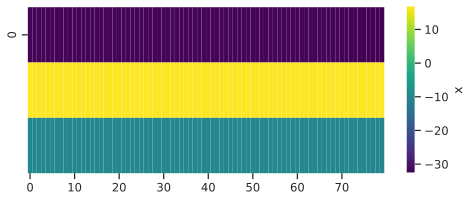

In [36]:
sns.heatmap(traj_pred[selected_agents, :, 0], cmap='viridis', cbar_kws={'label': 'x'}, xticklabels=10, yticklabels=10)

In [78]:
traj_pred.shape

(32, 80, 5)

In [20]:
traj_pred.shape

(32, 80, 5)

In [22]:
is_controlled

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True]], device='cuda:0')

In [13]:
frames = []

for i in range(80):
    t = i % replan_freq
    if t == 0:
        print("Replan at ", i)
        
        # Obtain all info for diffusion model (warmup)
        sample_batch = env.warmup_trajectory

        # Make a prediction
        pred = model.sample_denoiser(sample_batch)#, x_t=x_t)
        traj_pred = pred['denoised_trajs'].cpu().numpy()[0]

    # TODO: Convert sample to action
    action_sample = traj_pred[:, t, :]
    action = sample_to_action(action_sample, is_controlled, agents_id=selected_agents)
    
    # Step the environment with predicted actions
    env.step_dynamics(action)
    
    # TODO: Render the environment
    frame = env.render(world_render_idx=0)
    frames.append(frame)

Replan at  0


Diffusion:   0%|          | 0/50 [00:00<?, ?it/s]

Diffusion: 100%|██████████| 50/50 [00:01<00:00, 37.10it/s]


ValueError: Invalid agents_id size

### Todo: Show generated trajectories without goal guidance

In [ ]:
# Takes a list of frames of shape (H, W, 3) and displays them as a video
mediapy.show_video(frames, fps=10)

## Generate goal positions